In [1]:
import os
import time
import torch
import numpy as np
from torch.utils import data
from loader.real_data_loader import real_data_loader
from utils.data import *
from models.unet import Unet
from models.utils import *
from models.discriminator import Basic_D
from utils.train import *
from IPython.display import clear_output

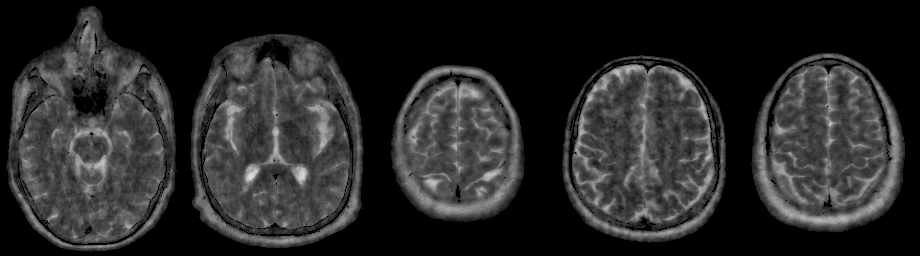

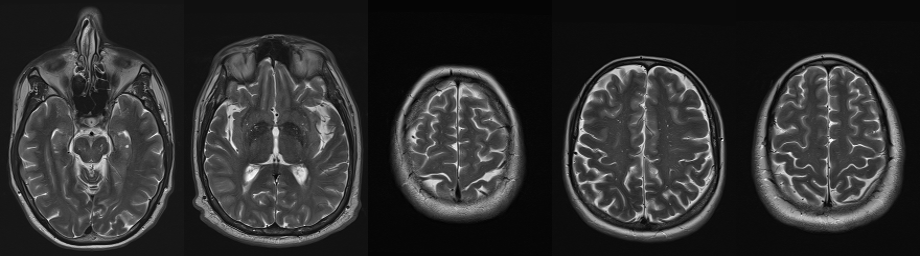

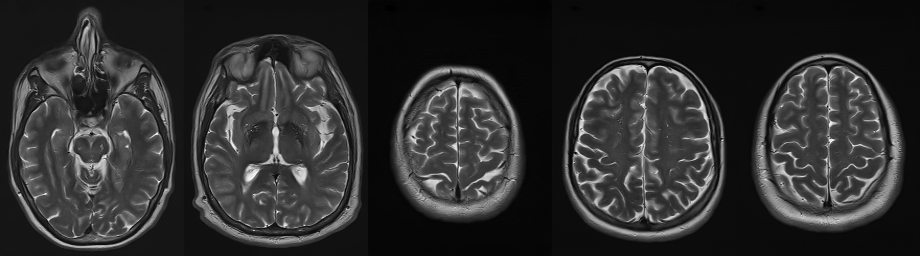

epochs: [150/150], batchs: [225/276], Loss_D: 0.349028, Loss_G: 3.245530, loss_L1: 0.012295, time: 63819s


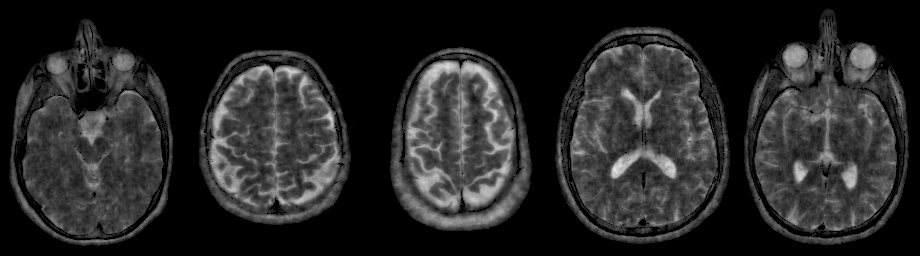

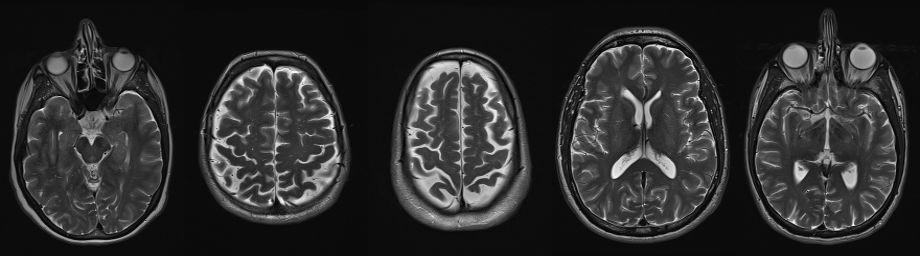

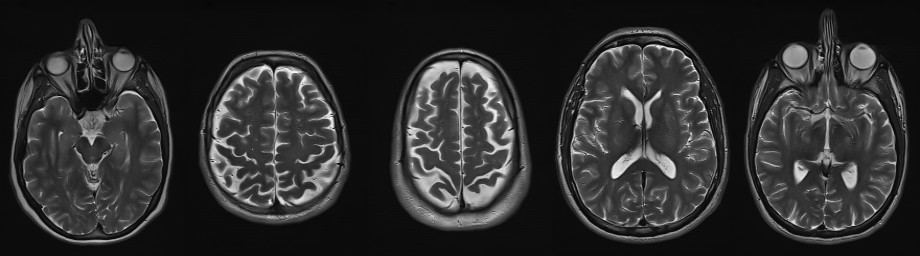

epochs: [150/150], batchs: [235/276], Loss_D: 0.360680, Loss_G: 3.724381, loss_L1: 0.012446, time: 63832s


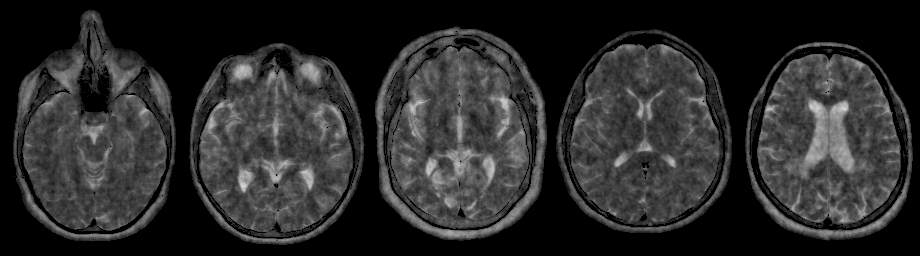

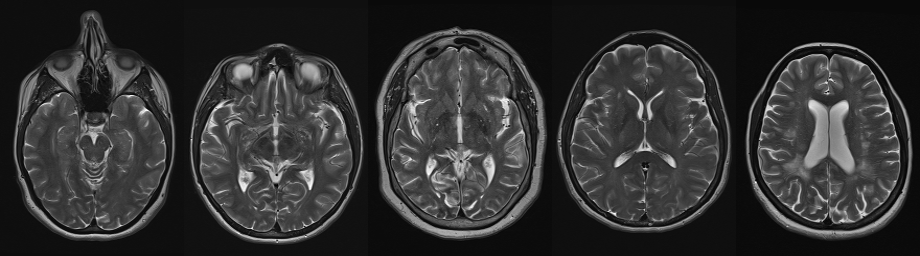

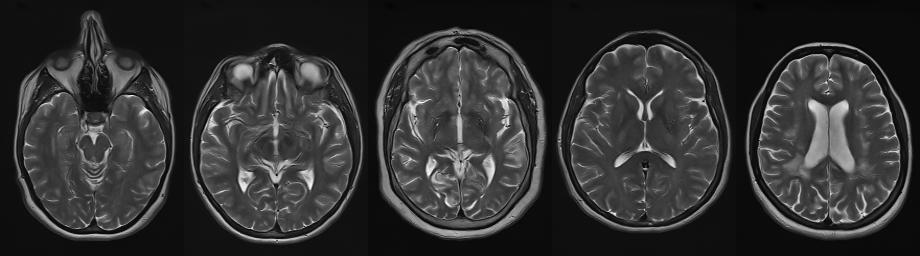

epochs: [150/150], batchs: [245/276], Loss_D: 0.292320, Loss_G: 4.216537, loss_L1: 0.012792, time: 63845s


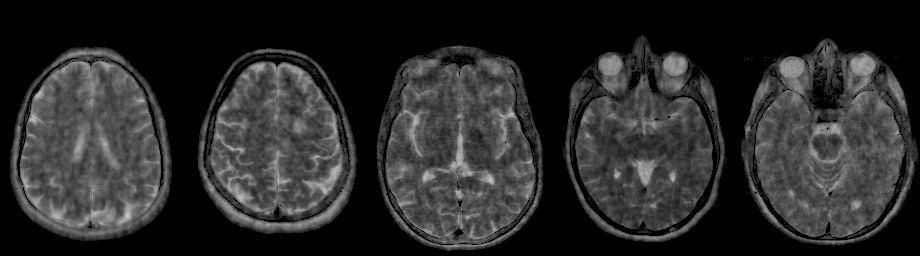

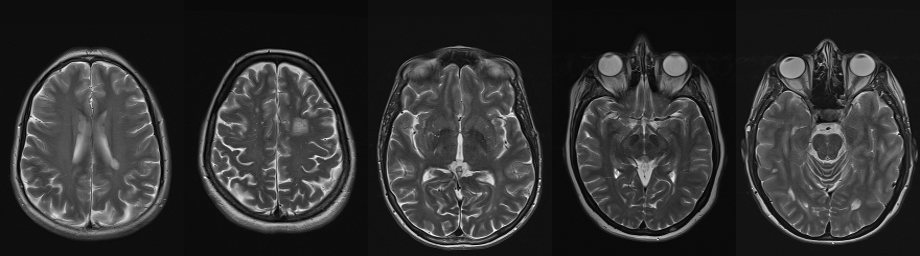

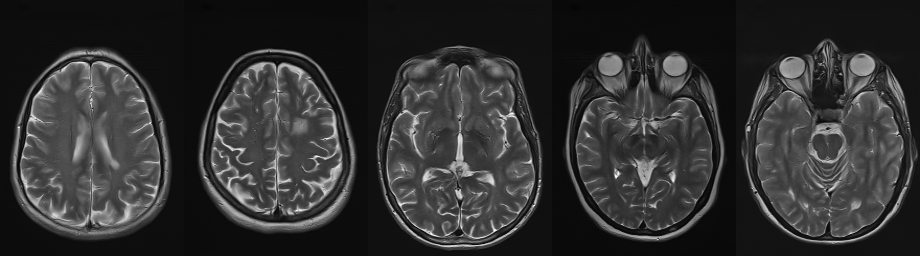

epochs: [150/150], batchs: [255/276], Loss_D: 0.299719, Loss_G: 4.501533, loss_L1: 0.012955, time: 63858s


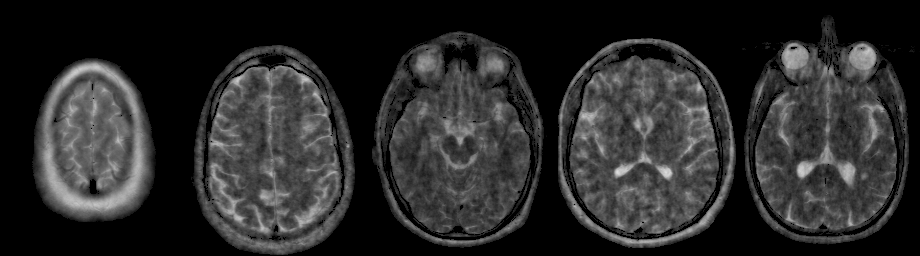

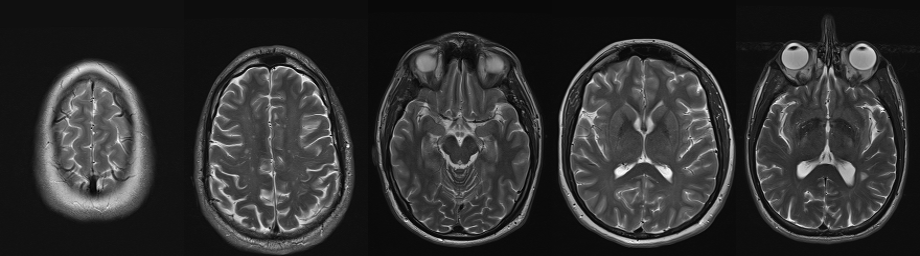

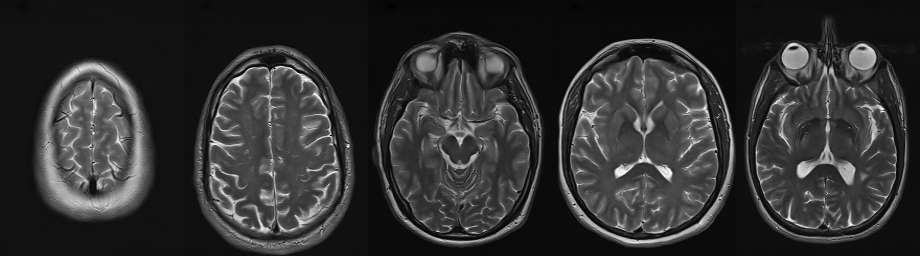

epochs: [150/150], batchs: [265/276], Loss_D: 0.418129, Loss_G: 3.211853, loss_L1: 0.012622, time: 63871s


In [2]:
if __name__ == '__main__':

    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    lrG = lrD = 2e-4
    niter = 150
    batch_size = 32
    epoch = 0
    gen_iterations = 0
    errL1_sum = errG_sum = errD_sum = 0
    
    display_iters = 10
    lambda_l1 = 1000

    t0 = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataLoader = real_data_loader(split='train')
    trainLoader = data.DataLoader(dataLoader, batch_size=batch_size, shuffle=True)

    netG = Unet(input_channels=2, output_channels=1, num_filters=[2**i for i in range(5, 10)])
    netD = Basic_D(input_channels=2, output_channels=1, num_filters=[32, 64, 128, 256])
    netG.to(device)
    netD.to(device)

    optimizerD, optimizerG = get_optimizers(netG, netD, lrG, lrD)
    print('haha')
    print(netG)
    
    while epoch < niter: 
        
        epoch += 1
        for idx, (inputs, targets) in enumerate(trainLoader):
            
            if gen_iterations%display_iters == 0:
                if gen_iterations%(5*display_iters) == 0:           
                    clear_output()
                
                sampling = True
                inputs_show, idxs = showImage(inputs, sampling=sampling)
                
                sampling = False
                targets_show, idxs = showImage(targets, idxs=idxs, sampling=sampling)

                inputs = inputs.to(device)
                outputs = netG(inputs)
                outputs_np = np.squeeze(np.asarray(outputs.cpu().detach()))
                outputs_show, idxs = showImage(outputs_np, idxs=idxs, sampling=sampling)

                print('epochs: [%d/%d], batchs: [%d/%d], Loss_D: %f, Loss_G: %f, loss_L1: %f, time: %ds'
                % (epoch, niter, idx, 8800//batch_size+1, errD_sum/display_iters, 
                errG_sum/display_iters, errL1_sum/display_iters, time.time()-t0))
                errL1_sum = errG_sum = errD_sum = 0
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            errD = netD_train(inputs, targets, netD, netG, optimizerD)
            errD_sum += errD

            errG, errL1 = netG_train(inputs, targets, netD, netG, optimizerG, lambda_l1)
            errG_sum += errG
            errL1_sum += errL1

            gen_iterations += 1